# **Machine Learning Model For Insurance Premium Prediction**

Project Objective:

        Accurately predict health insurance premiums for individuals using machine learning.

        Enable insurers to offer fair, personalized pricing while managing risk effectively.

        Identify key health and demographic factors that influence insurance costs.
      
**Goals:**

        Prepare data: handle missing values, outliers.

        Feature engineering: BMI, AgeGroup, ChronicConditionCount, interactions, HealthRiskScore.

        Scale numeric features, encode categorical/binary features.

**Model Selection:**

        Linear Regression: baseline, interpretable.

        Tree-based models: Decision Tree, Random Forest, Gradient Boosting for non-linear relationships.

**Evaluation:**

        Cross-validation (k-fold) for robust performance.

        Metrics: RMSE, MAE, R².

        Optional: prediction intervals for reliability.

**Interpretability:**

        Feature importance (tree-based or SHAP).

        Identify key risk factors affecting premiums.

In [58]:
# importing libraries
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
# loading data
df = pd.read_csv('insurance.csv')
df.head()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000


In [5]:
print(df.isnull().sum())

Age                        0
Diabetes                   0
BloodPressureProblems      0
AnyTransplants             0
AnyChronicDiseases         0
Height                     0
Weight                     0
KnownAllergies             0
HistoryOfCancerInFamily    0
NumberOfMajorSurgeries     0
PremiumPrice               0
dtype: int64


In [6]:
# Check for unusual values
print(df.describe())

              Age    Diabetes  BloodPressureProblems  AnyTransplants  \
count  986.000000  986.000000             986.000000      986.000000   
mean    41.745436    0.419878               0.468560        0.055781   
std     13.963371    0.493789               0.499264        0.229615   
min     18.000000    0.000000               0.000000        0.000000   
25%     30.000000    0.000000               0.000000        0.000000   
50%     42.000000    0.000000               0.000000        0.000000   
75%     53.000000    1.000000               1.000000        0.000000   
max     66.000000    1.000000               1.000000        1.000000   

       AnyChronicDiseases      Height      Weight  KnownAllergies  \
count          986.000000  986.000000  986.000000      986.000000   
mean             0.180527  168.182556   76.950304        0.215010   
std              0.384821   10.098155   14.265096        0.411038   
min              0.000000  145.000000   51.000000        0.000000   
25%   

Though we do not have missing values, let's add some logic for it

In [8]:
# Impute missing values
# Numeric features

numeric_features = ['Age', 'Height', 'Weight', 'NumberOfMajorSurgeries']
num_imputer = SimpleImputer(strategy='median')  # or strategy='mean'
df[numeric_features] = num_imputer.fit_transform(df[numeric_features])

In [9]:
# Binary features
binary_features = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
                   'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

binary_imputer = SimpleImputer(strategy='most_frequent')
df[binary_features] = binary_imputer.fit_transform(df[binary_features])

# **Feature Engineering**

In [10]:
# Create BMI
# Convert height from cm to meters
df['Height_m'] = df['Height'] / 100
df['BMI'] = df['Weight'] / (df['Height_m'] ** 2)

In [11]:
# AgeGroup
bins = [17, 30, 45, 66]  # define bins
labels = ['18-30', '31-45', '46-66']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

In [12]:
# ChronicConditionCount
df['ChronicConditionCount'] = df['Diabetes'] + df['BloodPressureProblems'] + df['AnyChronicDiseases']

# **Scaling and Encoding**

In [14]:
# Scaling numerical features

num_features = ['Age', 'Height', 'Weight', 'BMI', 'NumberOfMajorSurgeries']
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [15]:
# Encoding categorical features
df = pd.get_dummies(df, columns=['AgeGroup'], drop_first=True)

In [18]:
# Weight-to-Height Ratio
df['Weight_Height_Ratio'] = df['Weight'] / df['Height']

In [19]:
# Chronic Conditions × Age
df['Age_ChronicInteraction'] = df['Age'] * df['ChronicConditionCount']

In [20]:
# Surgeries × Chronic Conditions
df['Surgery_ChronicInteraction'] = df['NumberOfMajorSurgeries'] * df['ChronicConditionCount']

In [21]:
# Health Risk Scores
df['HealthRiskScore'] = (2*df['Diabetes'] + 1.5*df['BloodPressureProblems'] +
                         2.5*df['AnyChronicDiseases'] + df['HistoryOfCancerInFamily'])

In [22]:
# Age Buckets Beyond Simple Groups
df['AgeQuantile'] = pd.qcut(df['Age'], 4, labels=False)  # 4 quantiles

In [23]:
# Family/Medical History Features
df['FamilyHealthRisk'] = df['AnyChronicDiseases'] + df['HistoryOfCancerInFamily']

In [24]:
# Lifestyle
df['Obese'] = (df['BMI'] >= 30).astype(int)

In [25]:
# Surgery Burden
df['SurgeryBurden'] = pd.cut(df['NumberOfMajorSurgeries'], bins=[-1,0,1,3], labels=['None','Low','High'])

In [26]:
print(df.dtypes)

Age                            float64
Diabetes                         int64
BloodPressureProblems            int64
AnyTransplants                   int64
AnyChronicDiseases               int64
Height                         float64
Weight                         float64
KnownAllergies                   int64
HistoryOfCancerInFamily          int64
NumberOfMajorSurgeries         float64
PremiumPrice                     int64
Height_m                       float64
BMI                            float64
ChronicConditionCount            int64
AgeGroup_31-45                    bool
AgeGroup_46-66                    bool
Weight_Height_Ratio            float64
Age_ChronicInteraction         float64
Surgery_ChronicInteraction     float64
HealthRiskScore                float64
AgeQuantile                      int64
FamilyHealthRisk                 int64
Obese                            int64
SurgeryBurden                 category
dtype: object


# **ML Modeling - Prepare Data for Modeling**

In [27]:
X = df.drop('PremiumPrice', axis=1)
y = df['PremiumPrice']

In [28]:
# Handle categorical features
X = pd.get_dummies(X, columns=['SurgeryBurden'], drop_first=True)

In [30]:
# Split into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression (Baseline Model)**

In [32]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [34]:
# Evaluate performance
y_pred = lr_model.predict(X_test)
print("RMSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

RMSE: 9264384.065560339
MAE: 2148.8645406668325
R2 Score: 0.7827444281107023


In [35]:
# Check coefficients for feature importance
feature_importance = pd.DataFrame({'Feature': X.columns, 'Coefficient': lr_model.coef_})
print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False))

                       Feature  Coefficient
3               AnyTransplants  7462.053921
14              AgeGroup_46-66  7101.380932
13              AgeGroup_31-45  5512.071540
0                          Age  3342.708470
6                       Weight  2023.043965
11                         BMI -1211.228788
20            FamilyHealthRisk  1050.188331
19                 AgeQuantile  -804.352492
1                     Diabetes  -739.894757
5                       Height  -723.841933
22           SurgeryBurden_Low   650.277396
4           AnyChronicDiseases   635.906732
16      Age_ChronicInteraction  -487.444514
8      HistoryOfCancerInFamily   414.281598
9       NumberOfMajorSurgeries  -328.608763
18             HealthRiskScore   326.844304
12       ChronicConditionCount  -235.597766
2        BloodPressureProblems  -131.609741
7               KnownAllergies  -116.848513
10                    Height_m   -73.057603
23          SurgeryBurden_High    60.534161
15         Weight_Height_Ratio  

**Decision Tree Regressor**

In [37]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)  # max_depth to reduce overfitting
dt_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

In [39]:
# Evaluate performance
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree RMSE:", mean_squared_error(y_test, y_pred_dt))
print("Decision Tree R2:", r2_score(y_test, y_pred_dt))

Decision Tree RMSE: 5689461.284878939
Decision Tree R2: 0.8665785921178095


In [40]:
# Feature importance

feature_importance_dt = pd.DataFrame({'Feature': X.columns, 'Importance': dt_model.feature_importances_})
print(feature_importance_dt.sort_values(by='Importance', ascending=False))

                       Feature  Importance
0                          Age    0.704445
3               AnyTransplants    0.113172
6                       Weight    0.045837
4           AnyChronicDiseases    0.026759
20            FamilyHealthRisk    0.022815
15         Weight_Height_Ratio    0.021126
9       NumberOfMajorSurgeries    0.018621
2        BloodPressureProblems    0.015430
5                       Height    0.013524
11                         BMI    0.009436
17  Surgery_ChronicInteraction    0.003427
14              AgeGroup_46-66    0.003241
19                 AgeQuantile    0.002165
1                     Diabetes    0.000000
7               KnownAllergies    0.000000
10                    Height_m    0.000000
12       ChronicConditionCount    0.000000
13              AgeGroup_31-45    0.000000
8      HistoryOfCancerInFamily    0.000000
16      Age_ChronicInteraction    0.000000
18             HealthRiskScore    0.000000
21                       Obese    0.000000
22         

**Random Forest Regressor**

In [42]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, n_estimators=200, random_state=42)

In [44]:
# Evaluate performance
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 5699235.970613663
Random Forest R2: 0.8663493696541996


In [45]:
# Feature importance
feature_importance_rf = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
print(feature_importance_rf.sort_values(by='Importance', ascending=False))

                       Feature  Importance
0                          Age    0.608920
3               AnyTransplants    0.091370
6                       Weight    0.060870
15         Weight_Height_Ratio    0.052651
11                         BMI    0.027376
9       NumberOfMajorSurgeries    0.021621
4           AnyChronicDiseases    0.019715
20            FamilyHealthRisk    0.019657
16      Age_ChronicInteraction    0.018177
17  Surgery_ChronicInteraction    0.013784
10                    Height_m    0.013138
5                       Height    0.011343
8      HistoryOfCancerInFamily    0.010074
14              AgeGroup_46-66    0.008090
18             HealthRiskScore    0.006473
2        BloodPressureProblems    0.004765
1                     Diabetes    0.003183
12       ChronicConditionCount    0.002460
22           SurgeryBurden_Low    0.002109
23          SurgeryBurden_High    0.002024
19                 AgeQuantile    0.000858
7               KnownAllergies    0.000830
13         

**Gradient Boosting Machines (XGBoost / LightGBM)**

In [47]:
xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
# Evaluate performance
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost RMSE:", mean_squared_error(y_test, y_pred_xgb))
print("XGBoost R2:", r2_score(y_test, y_pred_xgb))

XGBoost RMSE: 5738102.5
XGBoost R2: 0.865437924861908


In [50]:
# Feature importance
xgb_importance = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
print(xgb_importance.sort_values(by='Importance', ascending=False))

                       Feature  Importance
3               AnyTransplants    0.295866
0                          Age    0.210831
4           AnyChronicDiseases    0.095494
20            FamilyHealthRisk    0.089955
9       NumberOfMajorSurgeries    0.068664
6                       Weight    0.045107
8      HistoryOfCancerInFamily    0.042909
2        BloodPressureProblems    0.023709
15         Weight_Height_Ratio    0.022422
7               KnownAllergies    0.015194
17  Surgery_ChronicInteraction    0.014567
11                         BMI    0.014464
5                       Height    0.013040
22           SurgeryBurden_Low    0.012340
16      Age_ChronicInteraction    0.010652
1                     Diabetes    0.008899
12       ChronicConditionCount    0.006213
18             HealthRiskScore    0.005384
13              AgeGroup_31-45    0.004292
10                    Height_m    0.000000
14              AgeGroup_46-66    0.000000
19                 AgeQuantile    0.000000
21         

***Model Comparision***

In [51]:
# Creating the models

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42)
}

In [53]:
results = []

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

In [54]:
# Create comparison table
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print(results_df)

               Model          RMSE          MAE        R2
1      Decision Tree  5.689461e+06  1244.826604  0.866579
2      Random Forest  5.699236e+06  1178.751778  0.866349
3            XGBoost  5.738102e+06  1329.295410  0.865438
0  Linear Regression  9.264384e+06  2148.864541  0.782744


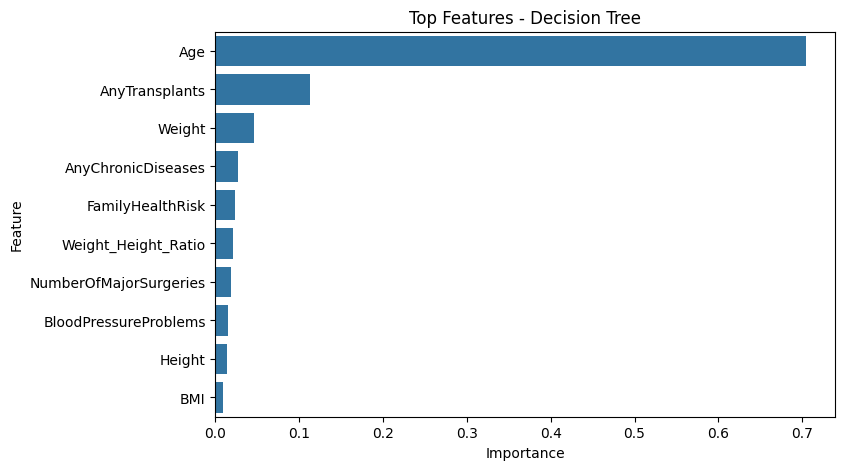

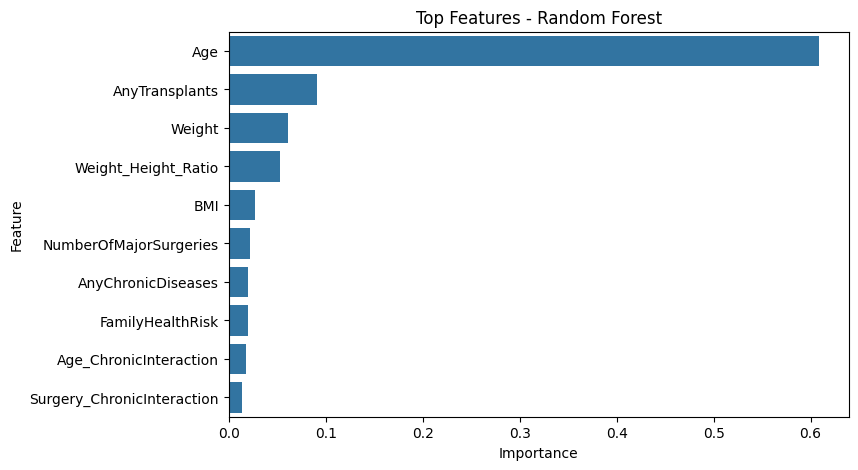

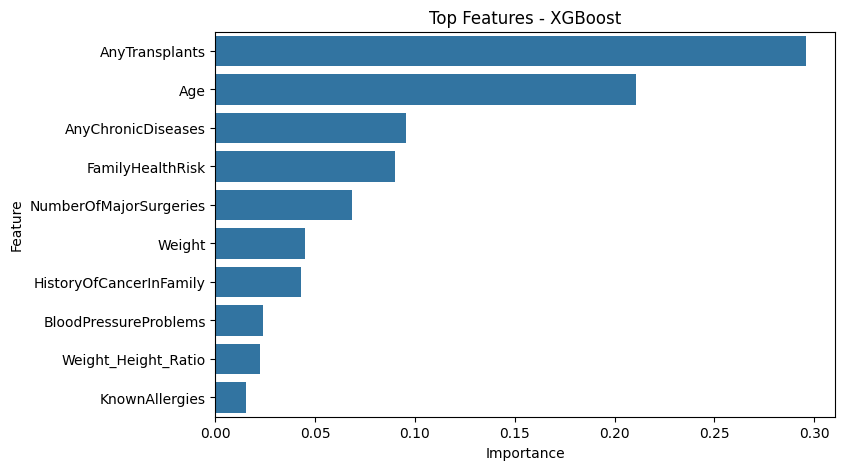

In [57]:
# Feature Importance

for name, model in models.items():
    if name != 'Linear Regression':
        if hasattr(model, 'feature_importances_'):
            fi = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
            fi = fi.sort_values(by='Importance', ascending=False).head(10)

            plt.figure(figsize=(8,5))
            sns.barplot(x='Importance', y='Feature', data=fi)
            plt.title(f'Top Features - {name}')
            plt.show()


**Interpretation**

Decision Tree, Random Forest, and XGBoost all perform similarly well, with R² around 0.865–0.867, meaning they explain about 87% of the variance in the target variable.

Their MAE is much lower (~1,178–1,329) compared to Linear Regression (~2,149), indicating more accurate average predictions.

RMSE is also lower (~5.69–5.74M) for tree-based models than Linear Regression (~9.26M), suggesting fewer extreme errors or outliers in predictions.

Linear Regression underperforms: it has the lowest R² (0.78) and the highest errors, both MAE and RMSE, indicating it struggles to capture the complexity in the data.

Conclusion:

Tree-based models (Decision Tree, Random Forest, XGBoost) are clearly superior to Linear Regression for this dataset, with Random Forest having the lowest MAE and a strong balance between accuracy and variance explanation. Linear Regression is not suitable here due to high errors and lower predictive power.



**Save the Model**

In [59]:
joblib.dump(rf_model, 'random_forest_insurance_model.pkl')
joblib.dump(dt_model, 'decision_tree_model.pkl')
joblib.dump(xgb_model, 'xgboost_model.pkl')
joblib.dump(lr_model, 'linear_regression_model.pkl')

print("Models saved successfully!")

Models saved successfully!


**Testing the saved model**

In [60]:
loaded_rf_model = joblib.load('random_forest_insurance_model.pkl')
loaded_dt_model = joblib.load('decision_tree_model.pkl')
loaded_xgb_model = joblib.load('xgboost_model.pkl')
loaded_lr_model = joblib.load('linear_regression_model.pkl')

In [66]:
# picking the first record to evaluate the model
X_sample = X_test.iloc[[0]]
y_actual = y_test.iloc[0].item()

In [67]:
# Store models in a dictionary for easy iteration
models = {
    "Random Forest": loaded_rf_model,
    "Decision Tree": loaded_dt_model,
    "XGBoost": loaded_xgb_model,
    "Linear Regression": loaded_lr_model
}

# Predict and print results
for name, model in models.items():
    y_pred = model.predict(X_sample)
    print(f"{name} Prediction: {y_pred[0]:.2f}, Actual: {y_actual}")

Random Forest Prediction: 29836.17, Actual: 31000
Decision Tree Prediction: 28601.27, Actual: 31000
XGBoost Prediction: 30642.93, Actual: 31000
Linear Regression Prediction: 29980.79, Actual: 31000


In [73]:
X_sample

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,...,AgeGroup_46-66,Weight_Height_Ratio,Age_ChronicInteraction,Surgery_ChronicInteraction,HealthRiskScore,AgeQuantile,FamilyHealthRisk,Obese,SurgeryBurden_Low,SurgeryBurden_High
613,0.591458,0,0,0,0,-0.315322,0.494443,1,1,0.444239,...,True,-1.568056,0.0,0.0,1.0,2,1,0,True,False
